In [1]:
import os
import re
import math
import argparse
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 스타일 설정 (한글 폰트 설정이 필요하다면 별도 추가 필요, 여기선 기본값)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# -----------------------
# [설정] 실행 파라미터 (argparse 대체)
# -----------------------
class Config:
    LOG_DIR = "./logs"          # 로그 파일이 위치한 경로 (WSL 경로)
    MIN_LAP_TIME = 20.0         # 첫 랩 완주로 인정할 최소 시간 (초)
    GOAL_RADIUS = 1.0           # 시작점으로 돌아왔다고 볼 거리 임계값 (m)
    MAPS = ["Spielberg", "hairpin_combo"] # 합산할 맵 이름 리스트

config = Config()

# 로그 디렉토리 확인
if not os.path.exists(config.LOG_DIR):
    print(f"경고: '{config.LOG_DIR}' 경로가 존재하지 않습니다. 경로를 확인해주세요.")
    os.makedirs(config.LOG_DIR, exist_ok=True) # 테스트를 위해 생성 (실제 파일 넣어주셔야 함)

In [2]:
# -----------------------
# 1) 파일명 파싱
# -----------------------
FNAME_PATTERN = re.compile(
    r'(?P<map>.+)_SPD(?P<spd>[\d.]+)_TGT(?P<tgt>[\d.]+)_ACC(?P<acc>[\d.]+)_CRV(?P<crv>[\d.]+)_FRENET_(?P<stamp>\d+)_(?P<result>[A-Z]+)_dur_(?P<dur>[\d.]+)s\.csv'
)

def parse_filename(fname: str):
    m = FNAME_PATTERN.match(fname)
    if not m:
        return None
    d = m.groupdict()
    for k in ["spd", "tgt", "acc", "crv", "dur"]:
        d[k] = float(d[k])
    return d

# -----------------------
# 2) CSV에서 수치 구간만 추출
# -----------------------
def _is_float_str(s):
    try:
        float(s)
        return True
    except Exception:
        return False

def extract_numeric(df: pd.DataFrame) -> pd.DataFrame:
    mask = df["t"].apply(
        lambda v: (
            isinstance(v, (int, float))
            or (isinstance(v, str) and _is_float_str(v))
        )
    )
    num = df[mask].copy()
    if num.empty:
        return num

    for col in ["t", "x", "y"]:
        num[col] = num[col].astype(float)
    return num

# -----------------------
# 3) 첫 랩 완주 시점 추정
# -----------------------
def calc_first_lap_time(num_df: pd.DataFrame, min_lap_time: float = 10.0, goal_radius: float = 1.0):
    if num_df.empty:
        return None
    x0, y0 = num_df["x"].iloc[0], num_df["y"].iloc[0]
    for _, row in num_df.iterrows():
        t = row["t"]
        if t < min_lap_time:
            continue
        d = math.hypot(row["x"] - x0, row["y"] - y0)
        if d < goal_radius:
            return t
    return None

# -----------------------
# 4) 개별 파일 분석
# -----------------------
def analyze_run(path: str, min_lap_time: float = 20.0, goal_radius: float = 1.0) -> dict:
    fname = os.path.basename(path)
    meta = parse_filename(fname)
    if meta is None:
        raise ValueError(f"파일명 형식이 예상과 다름: {fname}")

    df = pd.read_csv(path)

    finish_row = df.loc[df["t"] == "Finish Reason", "x"]
    finish_reason = finish_row.iloc[0] if not finish_row.empty else meta["result"]

    duration_row = df.loc[df["t"] == "Duration (s)", "x"]
    duration_summary = float(duration_row.iloc[0]) if not duration_row.empty else None

    num = extract_numeric(df)
    duration_numeric = num["t"].iloc[-1] if not num.empty else 0.0

    info = {
        **meta,
        "finish_reason": finish_reason,
        "n_rows": len(df),
        "n_numeric": len(num),
        "duration_numeric": duration_numeric,
        "duration_summary": duration_summary,
        "abort_reason": None,
        "effective_time": None,
        "needs_rerun": False,
        "file_path": path # 추가: 나중에 상세 분석을 위해 경로 저장
    }

    result = meta["result"]

    if result == "GOAL":
        if duration_summary is not None:
            info["effective_time"] = duration_summary
        else:
            info["effective_time"] = duration_numeric
    elif result == "CRASH":
        info["abort_reason"] = "CRASH"
        info["needs_rerun"] = False
    elif result == "STUCK":
        info["abort_reason"] = "STUCK"
        info["needs_rerun"] = False
    elif result == "ABORT":
        if num.empty:
            info["abort_reason"] = "NO_MOTION"
            info["needs_rerun"] = True
        else:
            lap_time = calc_first_lap_time(num, min_lap_time, goal_radius)
            if lap_time is None:
                info["abort_reason"] = "EARLY_ABORT_NO_LAP"
                info["needs_rerun"] = True
            else:
                info["abort_reason"] = "MULTI_LAP_OR_MANUAL_ABORT_AFTER_LAP"
                info["effective_time"] = lap_time
                info["needs_rerun"] = False
    else:
        info["abort_reason"] = f"UNKNOWN_RESULT_{result}"
        info["needs_rerun"] = True

    return info

In [3]:
# -----------------------
# 로직 실행
# -----------------------
analyses = []
log_files = [f for f in os.listdir(config.LOG_DIR) if f.endswith(".csv") and "FRENET" in f]

print(f"총 {len(log_files)}개의 로그 파일을 발견했습니다.")

for fname in log_files:
    path = os.path.join(config.LOG_DIR, fname)
    try:
        info = analyze_run(
            path,
            min_lap_time=config.MIN_LAP_TIME,
            goal_radius=config.GOAL_RADIUS,
        )
        analyses.append(info)
    except Exception as e:
        print(f"[WARN] {fname} 분석 실패: {e}")

# 데이터프레임으로 변환 (분석 용이성을 위해)
df_results = pd.DataFrame(analyses)

if df_results.empty:
    print("분석할 데이터가 없습니다.")
else:
    print("분석 완료! 상위 5개 데이터 확인:")
    display(df_results.head())

총 196개의 로그 파일을 발견했습니다.
[WARN] hairpin_X1Hb_frenet_FRENET_1764787352_dur_37.64s.csv 분석 실패: 파일명 형식이 예상과 다름: hairpin_X1Hb_frenet_FRENET_1764787352_dur_37.64s.csv
[WARN] hairpin_X1He_frenet_FRENET_1764788367.csv 분석 실패: 파일명 형식이 예상과 다름: hairpin_X1He_frenet_FRENET_1764788367.csv
[WARN] spielberg_X1_frenet_FRENET_1764783215_dur_77.57s.csv 분석 실패: 파일명 형식이 예상과 다름: spielberg_X1_frenet_FRENET_1764783215_dur_77.57s.csv
[WARN] spielberg_FRENET_20251203_045505.csv 분석 실패: 파일명 형식이 예상과 다름: spielberg_FRENET_20251203_045505.csv
[WARN] hairpin_X1He_frenet_FRENET_1764788277_dur_61.06s.csv 분석 실패: 파일명 형식이 예상과 다름: hairpin_X1He_frenet_FRENET_1764788277_dur_61.06s.csv
[WARN] hairpin_X1Hb_frenet_FRENET_1764785319.csv 분석 실패: 파일명 형식이 예상과 다름: hairpin_X1Hb_frenet_FRENET_1764785319.csv
[WARN] spielberg_X1He_frenet_FRENET_1764789239_dur_83.35s.csv 분석 실패: 파일명 형식이 예상과 다름: spielberg_X1He_frenet_FRENET_1764789239_dur_83.35s.csv
[WARN] hairpin_X1Ha_frenet_FRENET_1764784143.csv 분석 실패: 파일명 형식이 예상과 다름: hairpin_X1Ha_frenet_FRENE

,map,spd,tgt,acc,crv,stamp,result,dur,finish_reason,n_rows,n_numeric,duration_numeric,duration_summary,abort_reason,effective_time,needs_rerun,file_path
0,Spielberg,6.0,5.2,6.0,0.95,1764828329,ABORT,0.00,MANUAL_ABORT (Force Quit),23496,23480,94.7032,0.00,MULTI_LAP_OR_MANUAL_ABORT_AFTER_LAP,79.3709,False,./logs\Spielberg_SPD6.0_TGT5.2_ACC6.0_CRV0.95_...
1,hairpin_combo,6.5,4.6,5.0,1.00,1764818919,GOAL,63.52,GOAL REACHED,15841,15825,63.5198,63.52,None,63.5200,False,./logs\hairpin_combo_SPD6.5_TGT4.6_ACC5.0_CRV1...
2,hairpin_combo,5.5,5.0,6.0,0.90,1764816892,ABORT,0.00,MANUAL_ABORT (Force Quit),16,0,0.0000,0.00,NO_MOTION,NaN,True,./logs\hairpin_combo_SPD5.5_TGT5.0_ACC6.0_CRV0...
3,Spielberg,5.5,4.6,6.0,1.00,1764823348,GOAL,92.23,GOAL REACHED,23070,23054,92.2316,92.23,None,92.2300,False,./logs\Spielberg_SPD5.5_TGT4.6_ACC6.0_CRV1.00_...
4,hairpin_combo,5.5,5.2,6.0,0.90,1764817257,CRASH,24.24,COLLISION DETECTED,6006,5990,24.2361,24.24,CRASH,NaN,False,./logs\hairpin_combo_SPD5.5_TGT5.2_ACC6.0_CRV0...


In [4]:
# -----------------------
# 5) 베스트 파라미터 찾기 및 출력
# -----------------------
def find_best_weights_df(df, map_names):
    # 피벗 테이블을 이용해 맵별 effective_time 정리
    # (spd, tgt, acc, crv) 그룹화
    
    # 유효한 기록만 필터링
    valid_df = df[df['effective_time'].notnull()]
    
    if valid_df.empty:
        return []

    # 맵별 최소 시간 찾기
    grouped = valid_df.groupby(['spd', 'tgt', 'acc', 'crv', 'map'])['effective_time'].min().unstack()
    
    # 모든 맵에 기록이 있는 경우만 필터링
    for m in map_names:
        if m not in grouped.columns:
            grouped[m] = None # 없는 맵 컬럼 생성 (에러 방지)
            
    complete_records = grouped.dropna(subset=map_names).copy()
    
    if complete_records.empty:
        return []

    # Total Time 계산
    complete_records['total_time'] = complete_records[map_names].sum(axis=1)
    
    # 정렬
    complete_records = complete_records.sort_values('total_time')
    return complete_records

# -----------------------
# 6) 재실험 후보 찾기
# -----------------------
def find_rerun_candidates_df(df, map_names):
    # 전체 가능한 파라미터 조합 추출
    params = df[['spd', 'tgt', 'acc', 'crv']].drop_duplicates()
    reruns = []
    
    for _, p in params.iterrows():
        for m in map_names:
            # 해당 파라미터 + 맵 조합의 유효 타임 존재 여부 확인
            subset = df[
                (df['spd'] == p['spd']) & 
                (df['tgt'] == p['tgt']) & 
                (df['acc'] == p['acc']) & 
                (df['crv'] == p['crv']) & 
                (df['map'] == m) &
                (df['effective_time'].notnull())
            ]
            if subset.empty:
                reruns.append({
                    "map": m, "spd": p['spd'], "tgt": p['tgt'], "acc": p['acc'], "crv": p['crv']
                })
    return pd.DataFrame(reruns)

# === 결과 출력 ===
best_results = find_best_weights_df(df_results, config.MAPS)
rerun_results = find_rerun_candidates_df(df_results, config.MAPS)

print("\n==== [Top 10] 두 맵 합산 타임 기준 베스트 파라미터 ====")
if len(best_results) == 0:
    print("두 맵 모두 완주한 파라미터 셋이 없습니다.")
else:
    display(best_results.head(10))

print("\n==== 재실험이 필요한 (파라미터, 맵) 목록 ====")
if rerun_results.empty:
    print("재실험이 필요한 조합이 없습니다.")
else:
    display(rerun_results)


==== [Top 10] 두 맵 합산 타임 기준 베스트 파라미터 ====


map               Spielberg  hairpin_combo  total_time
spd tgt acc crv                                       
5.5 5.0 6.0 1.00    76.3500        60.0800    136.4300
6.5 5.0 6.0 0.95    77.1900        61.8513    139.0413
6.0 5.0 6.0 0.90    82.1515        57.4600    139.6115
5.5 5.0 5.0 1.00    81.4316        60.2600    141.6916
6.0 4.8 6.0 0.95    81.2500        61.7900    143.0400
5.5 5.0 5.0 0.95    82.5700        61.0288    143.5988
6.5 5.0 5.0 0.90    81.8500        61.9602    143.8102
    4.8 6.0 0.95    81.5992        62.5300    144.1292
6.0 4.8 5.0 0.95    84.0799        60.5207    144.6006
        6.0 0.90    84.9317        59.8900    144.8217


==== 재실험이 필요한 (파라미터, 맵) 목록 ====


,map,spd,tgt,acc,crv
0,hairpin_combo,6.0,5.2,6.0,0.95
1,hairpin_combo,5.5,5.0,6.0,0.90
2,hairpin_combo,5.5,4.6,6.0,1.00
3,Spielberg,5.5,5.2,6.0,0.90
4,hairpin_combo,5.5,5.2,6.0,0.90
5,hairpin_combo,5.5,5.0,5.0,0.90
6,hairpin_combo,6.5,5.2,5.0,0.95
7,Spielberg,6.0,5.2,6.0,0.90
8,hairpin_combo,6.0,5.2,6.0,0.90
9,hairpin_combo,6.0,4.6,5.0,1.00


In [ ]:
import pandas as pd
import numpy as np

# ---------------------------------------------------------
# [Step 1] 로그 다시 로드 및 병합 (기존 로그 + 재실험 로그)
# ---------------------------------------------------------
def load_and_merge_logs(log_dir):
    # 실제로는 glob 등을 사용하여 log_dir 내의 모든 csv를 읽어와야 합니다.
    # 여기서는 예시로 기존 df와 재실험 df가 합쳐진 상태라고 가정하고
    # 중복(같은 파라미터, 같은 맵)이 있을 경우 '성공한 기록(최단 시간)'을 남기는 로직을 짭니다.
    
    # 예시: 모든 로그 파일을 읽어서 하나로 합쳤다고 가정
    # df_all = pd.concat([pd.read_csv(f) for f in all_log_files])
    
    # (사용자 환경에 맞춰 df_results를 갱신했다고 가정합니다)
    # df_updated = ... 
    
    # 중복 제거 로직: 같은 (map, params) 조합 중 effective_time이 가장 작은(좋은) 것 남기기
    # 실패(NaN)보다 성공(실수값)이 우선되도록 정렬 후 drop_duplicates
    
    # 편의상 현재 메모리에 있는 df_results가 업데이트 되었다고 가정하고 진행하겠습니다.
    return df_results 

# ---------------------------------------------------------
# [Step 2] 재실험 결과 상세 분석 함수
# ---------------------------------------------------------
def analyze_rerun_outcomes(df_current, df_targets):
    """
    df_current: 재실험 후 업데이트된 전체 데이터프레임
    df_targets: 아까 추출했던 '재실험이 필요한 목록' (rerun_results)
    """
    outcomes = []
    
    print(f"총 {len(df_targets)}개의 재실험 대상에 대한 분석을 시작합니다...\n")

    for idx, row in df_targets.iterrows():
        target_map = row['map']
        p_spd = row['spd']
        p_tgt = row['tgt']
        p_acc = row['acc']
        p_crv = row['crv']
        
        # 현재 데이터에서 해당 조합 찾기
        match = df_current[
            (df_current['map'] == target_map) &
            (df_current['spd'] == p_spd) &
            (df_current['tgt'] == p_tgt) &
            (df_current['acc'] == p_acc) &
            (df_current['crv'] == p_crv)
        ]
        
        # 결과 판별
        status = "Still Failed" # 기본값
        eff_time = None
        
        if not match.empty:
            # 유효한 시간 기록이 하나라도 있는지 확인
            valid_runs = match[match['effective_time'].notnull()]
            if not valid_runs.empty:
                status = "Success"
                eff_time = valid_runs['effective_time'].min()
            else:
                status = "Crash/Fail"
        else:
            status = "No Data" # 로그 자체가 없음

        outcomes.append({
            "map": target_map,
            "spd": p_spd,
            "tgt": p_tgt,
            "acc": p_acc,
            "crv": p_crv,
            "status": status,
            "new_time": eff_time
        })
        
    df_outcomes = pd.DataFrame(outcomes)
    return df_outcomes

# =========================================================
# [실행 예시]
# =========================================================

# 1. (가정) 재실험이 끝난 후, 로그를 다시 읽어 df_results를 갱신했다고 가정
# df_results = load_all_logs() ... 

# 2. 재실험 결과 분석
# rerun_results는 위에서 구한 '재실험이 필요한 목록'입니다.
df_rerun_analysis = analyze_rerun_outcomes(df_results, rerun_results)

# 3. 결과 출력
print("==== 재실험 결과 분석 (Success / Fail) ====")
display(df_rerun_analysis)

# 4. 성공률 요약
success_count = len(df_rerun_analysis[df_rerun_analysis['status'] == 'Success'])
total_count = len(df_rerun_analysis)
print(f"\n재실험 성공률: {success_count} / {total_count} ({(success_count/total_count)*100:.1f}%)")

# 5. 이제 데이터가 채워졌으므로, 베스트 파라미터를 다시 찾습니다.
print("\n==== [Updated] 재실험 데이터 포함 베스트 파라미터 랭킹 ====")
final_best_results = find_best_weights_df(df_results, config.MAPS)
display(final_best_results.head(10))

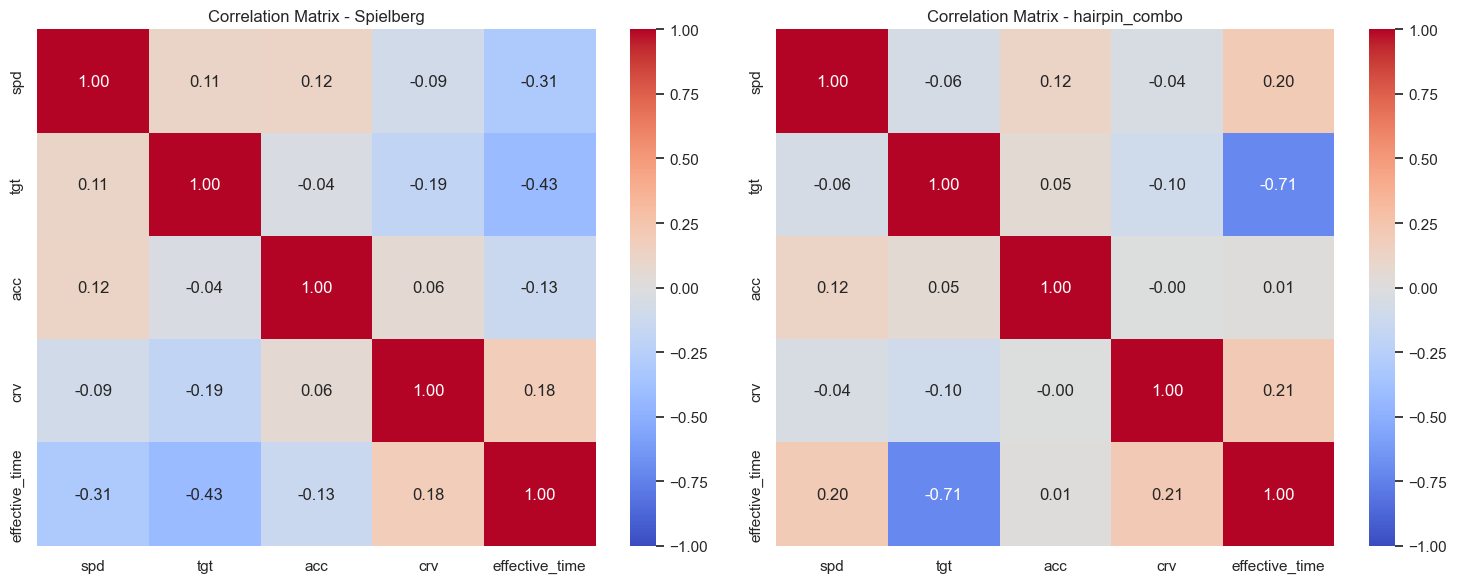

In [5]:
# 상관관계 분석을 위해 필요한 컬럼만 추출
if not df_results.empty and df_results['effective_time'].notnull().sum() > 0:
    # 맵별로 데이터를 나눠서 분석하는 것이 더 정확함
    maps_in_data = df_results['map'].unique()

    plt.figure(figsize=(15, 6))
    
    for i, map_name in enumerate(maps_in_data):
        plt.subplot(1, len(maps_in_data), i+1)
        
        # 해당 맵의 유효한 완주 데이터만 필터링
        target_df = df_results[(df_results['map'] == map_name) & (df_results['effective_time'].notnull())]
        
        if target_df.empty:
            plt.title(f"{map_name}: No Data")
            continue

        # 상관계수 계산
        corr_cols = ['spd', 'tgt', 'acc', 'crv', 'effective_time']
        corr = target_df[corr_cols].corr()
        
        # 히트맵 그리기
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
        plt.title(f"Correlation Matrix - {map_name}")
        
    plt.tight_layout()
    plt.show()
else:
    print("상관관계를 분석할 유효한 데이터가 부족합니다.")

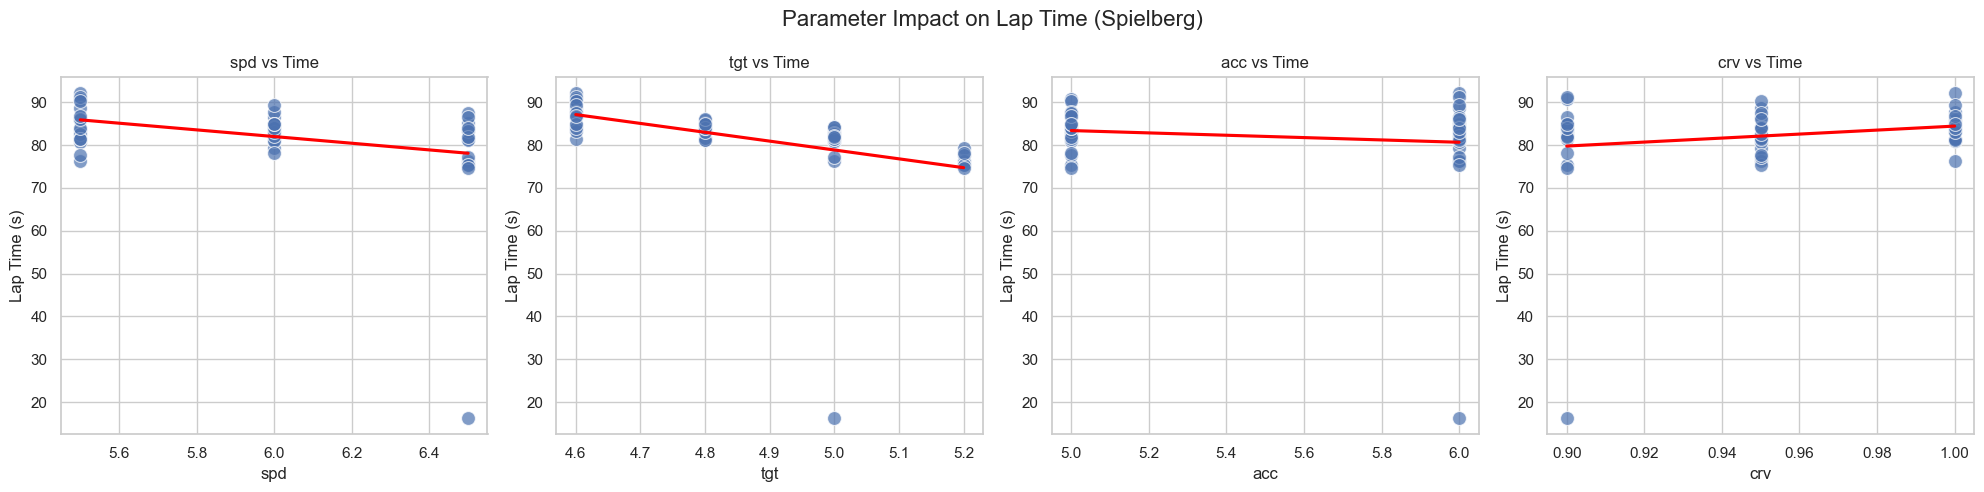

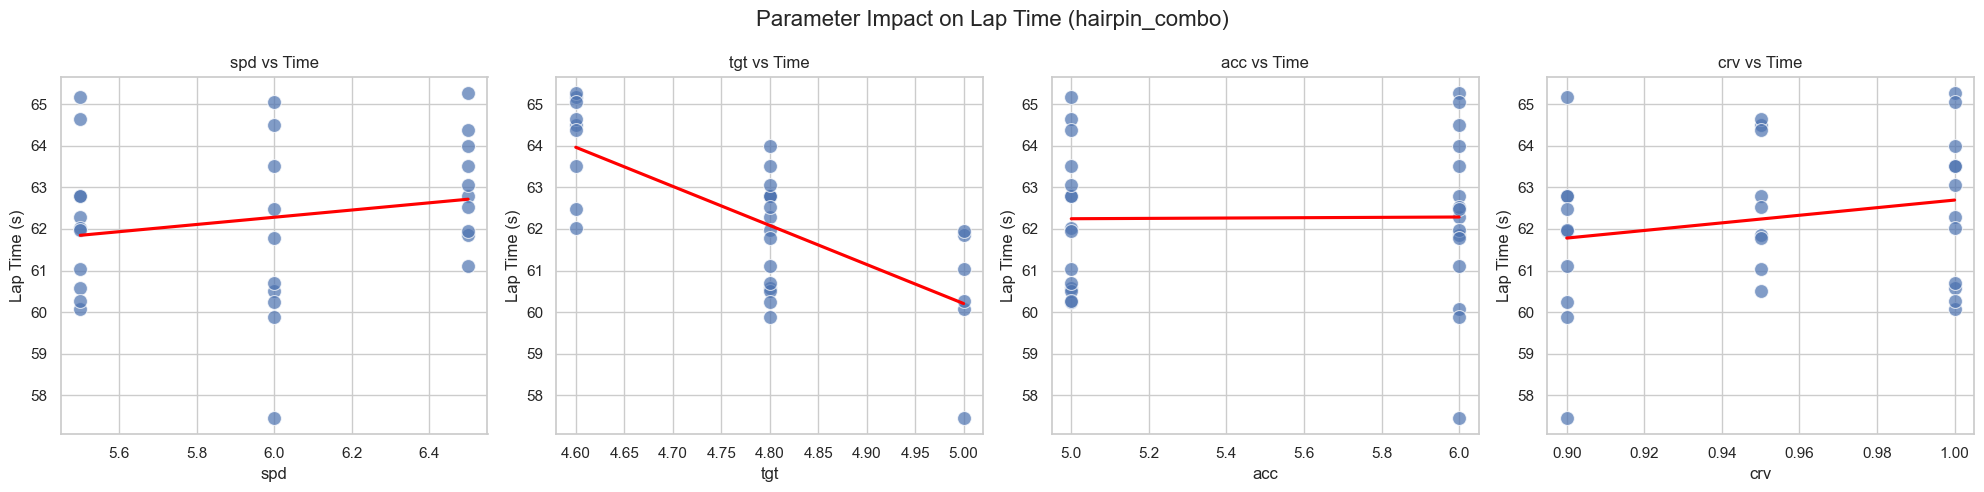

In [6]:
# 각 파라미터가 랩타임에 미치는 영향을 산점도로 시각화
if not df_results.empty:
    valid_df = df_results[df_results['effective_time'].notnull()]
    
    params = ['spd', 'tgt', 'acc', 'crv']
    
    for map_name in valid_df['map'].unique():
        map_df = valid_df[valid_df['map'] == map_name]
        
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        fig.suptitle(f"Parameter Impact on Lap Time ({map_name})", fontsize=16)
        
        for i, param in enumerate(params):
            sns.scatterplot(data=map_df, x=param, y='effective_time', ax=axes[i], s=100, alpha=0.7)
            
            # 추세선 추가 (데이터가 2개 이상일 때)
            if len(map_df) > 1:
                sns.regplot(data=map_df, x=param, y='effective_time', ax=axes[i], scatter=False, color='red', ci=None)
                
            axes[i].set_title(f"{param} vs Time")
            axes[i].set_ylabel("Lap Time (s)")
            
        plt.tight_layout()
        plt.show()

최고 기록 파라미터 분석: SPD=5.5, TGT=5.0, ACC=6.0, CRV=1.0
분석할 로그 파일: ./logs\Spielberg_SPD5.5_TGT5.0_ACC6.0_CRV1.00_FRENET_1764824534_GOAL_dur_76.35s.csv


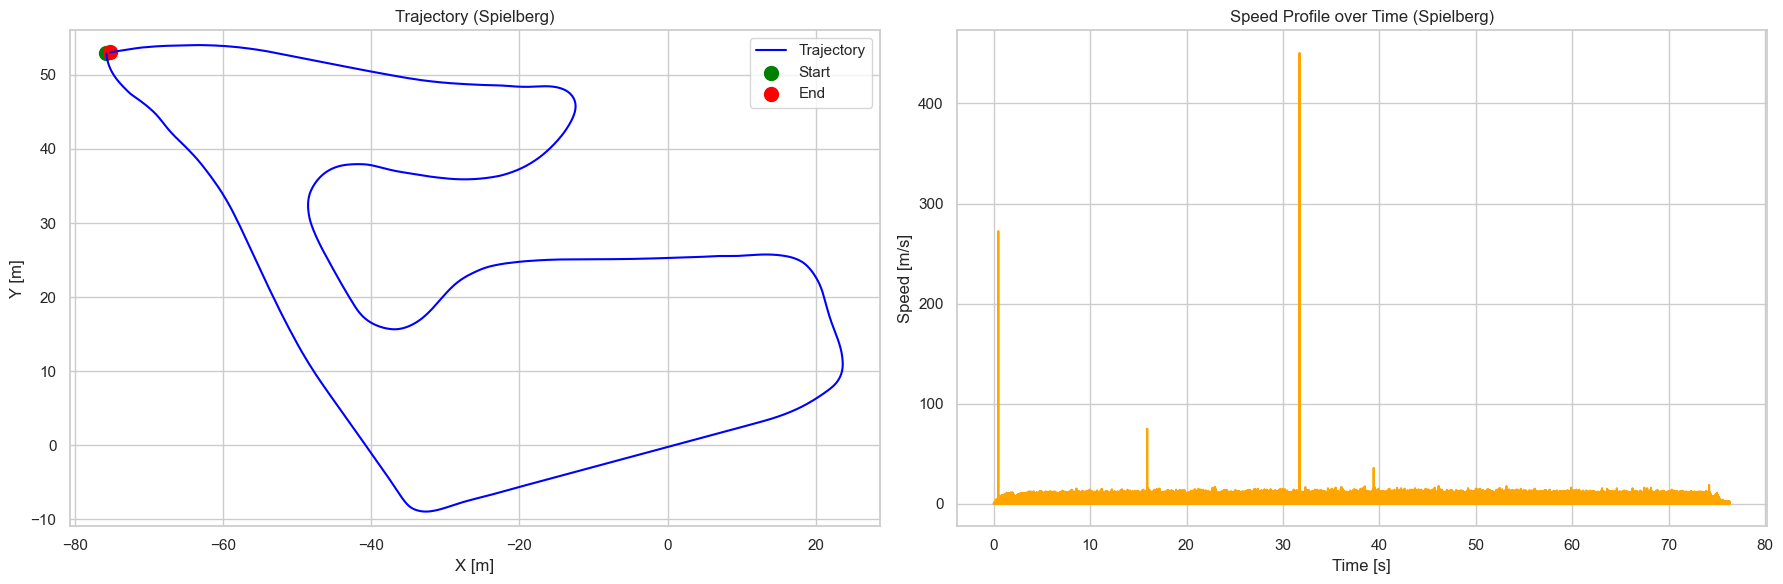

In [7]:
if len(best_results) > 0:
    # 가장 성적이 좋은 파라미터 조합 가져오기
    best_param = best_results.iloc[0].name # (spd, tgt, acc, crv) tuple
    print(f"최고 기록 파라미터 분석: SPD={best_param[0]}, TGT={best_param[1]}, ACC={best_param[2]}, CRV={best_param[3]}")
    
    # 해당 파라미터의 로그 파일 경로 찾기 (첫 번째 맵 기준)
    target_map = config.MAPS[0]
    best_run_row = df_results[
        (df_results['spd'] == best_param[0]) & 
        (df_results['tgt'] == best_param[1]) & 
        (df_results['acc'] == best_param[2]) & 
        (df_results['crv'] == best_param[3]) &
        (df_results['map'] == target_map)
    ].iloc[0]
    
    best_log_path = best_run_row['file_path']
    print(f"분석할 로그 파일: {best_log_path}")
    
    # 로그 로딩
    run_df = pd.read_csv(best_log_path)
    run_numeric = extract_numeric(run_df)
    
    # --- 시각화 ---
    plt.figure(figsize=(18, 6))
    
    # 1. 주행 경로 (X-Y)
    plt.subplot(1, 2, 1)
    plt.plot(run_numeric['x'], run_numeric['y'], label='Trajectory', color='blue')
    plt.scatter(run_numeric['x'].iloc[0], run_numeric['y'].iloc[0], c='green', s=100, label='Start')
    plt.scatter(run_numeric['x'].iloc[-1], run_numeric['y'].iloc[-1], c='red', s=100, label='End')
    plt.title(f"Trajectory ({target_map})")
    plt.xlabel("X [m]")
    plt.ylabel("Y [m]")
    plt.axis('equal')
    plt.legend()
    plt.grid(True)
    
    # 2. 시간축 속도 그래프 (속도 정보가 있다면)
    # 로그에 속도(v) 컬럼이 없다면 위치 변화로 속도 추정
    if 'v' in run_numeric.columns:
        velocities = run_numeric['v']
    else:
        # 위치 미분으로 속도 계산
        dx = run_numeric['x'].diff()
        dy = run_numeric['y'].diff()
        dt = run_numeric['t'].diff()
        velocities = (dx**2 + dy**2)**0.5 / dt
        velocities = velocities.fillna(0)

    plt.subplot(1, 2, 2)
    plt.plot(run_numeric['t'], velocities, color='orange')
    plt.title(f"Speed Profile over Time ({target_map})")
    plt.xlabel("Time [s]")
    plt.ylabel("Speed [m/s]")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

else:
    print("분석할 Best Result가 없습니다.")

In [11]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from scipy.optimize import minimize
import warnings

warnings.filterwarnings("ignore")

# -----------------------
# 1. 데이터 준비 (best_results 활용)
# -----------------------

# best_results(=complete_records)가 비어있는지 확인
if 'best_results' not in locals() or best_results.empty:
    print("❌ 솔버를 실행할 '성공한 주행 데이터'가 없습니다. 로그가 충분한지 확인해주세요.")
else:
    # 중요: MultiIndex로 되어 있는 파라미터들을 컬럼으로 꺼냅니다.
    solver_df = best_results.reset_index()
    
    print(f"✅ 학습에 사용할 데이터 개수: {len(solver_df)}개")

    # X: 입력 파라미터 (Speed, Target, Acc, Curvature)
    X_train = solver_df[['spd', 'tgt', 'acc', 'crv']].values
    
    # y: 목표값 (Total Time - 낮을수록 좋음)
    y_train = solver_df['total_time'].values

    # -----------------------
    # 2. 베이지안 최적화 모델 학습 (Gaussian Process)
    # -----------------------
    
    # 커널 설정 (RBF 계열 Matern 커널 + 노이즈 처리용 WhiteKernel)
    kernel = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5) + WhiteKernel(noise_level=1.0)

    # 모델 정의 (normalize_y=True: 타겟값 스케일링 자동 처리)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True, random_state=42)
    
    # 학습
    gp.fit(X_train, y_train)
    print("✅ 가우시안 프로세스 모델 학습 완료.")

    # -----------------------
    # 3. 최적 파라미터 탐색 (Minimize expected time)
    # -----------------------
    
    # 탐색 범위 (기존 데이터 범위를 참고하거나, 넓게 설정)
    bounds = [
        (2.0, 10.0), # spd
        (0.1, 3.0),  # tgt
        (0.1, 3.0),  # acc
        (0.1, 3.0)   # crv
    ]

    def expected_lap_time(x):
        x = x.reshape(1, -1)
        pred = gp.predict(x, return_std=False)
        return pred[0]

    best_pred_time = float('inf')
    best_params = None

    # 여러 시작점에서 최적해 탐색 (Local Minima 방지)
    for _ in range(30):
        x0 = [np.random.uniform(b[0], b[1]) for b in bounds]
        res = minimize(expected_lap_time, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < best_pred_time:
            best_pred_time = res.fun
            best_params = res.x

    # -----------------------
    # 4. 결과 리포트
    # -----------------------
    print("\n" + "="*40)
    print("🤖 [AI Solver] 최적 파라미터 제안")
    print("="*40)
    print(f"SPD (목표 속도)     : {best_params[0]:.2f}")
    print(f"TGT (경로 가중치)   : {best_params[1]:.2f}")
    print(f"ACC (가속도 가중치) : {best_params[2]:.2f}")
    print(f"CRV (곡률 가중치)   : {best_params[3]:.2f}")
    print("-" * 40)
    print(f"예상 합산 기록      : {best_pred_time:.2f} s")
    print(f"현재 데이터 최고 기록: {y_train.min():.2f} s")
    
    improvement = y_train.min() - best_pred_time
    if improvement > 0:
        print(f"👉 예상 개선 효과     : {improvement:.2f}초 단축 가능성 있음!")
    else:
        print("👉 분석: 현재 데이터가 이미 최적에 가깝습니다. 더 과감한 파라미터 변경이 필요할 수 있습니다.")

✅ 학습에 사용할 데이터 개수: 26개
✅ 가우시안 프로세스 모델 학습 완료.

🤖 [AI Solver] 최적 파라미터 제안
SPD (목표 속도)     : 8.44
TGT (경로 가중치)   : 2.63
ACC (가속도 가중치) : 1.72
CRV (곡률 가중치)   : 0.40
----------------------------------------
예상 합산 기록      : 146.31 s
현재 데이터 최고 기록: 136.43 s
👉 분석: 현재 데이터가 이미 최적에 가깝습니다. 더 과감한 파라미터 변경이 필요할 수 있습니다.


<Figure size 1000x1000 with 0 Axes>

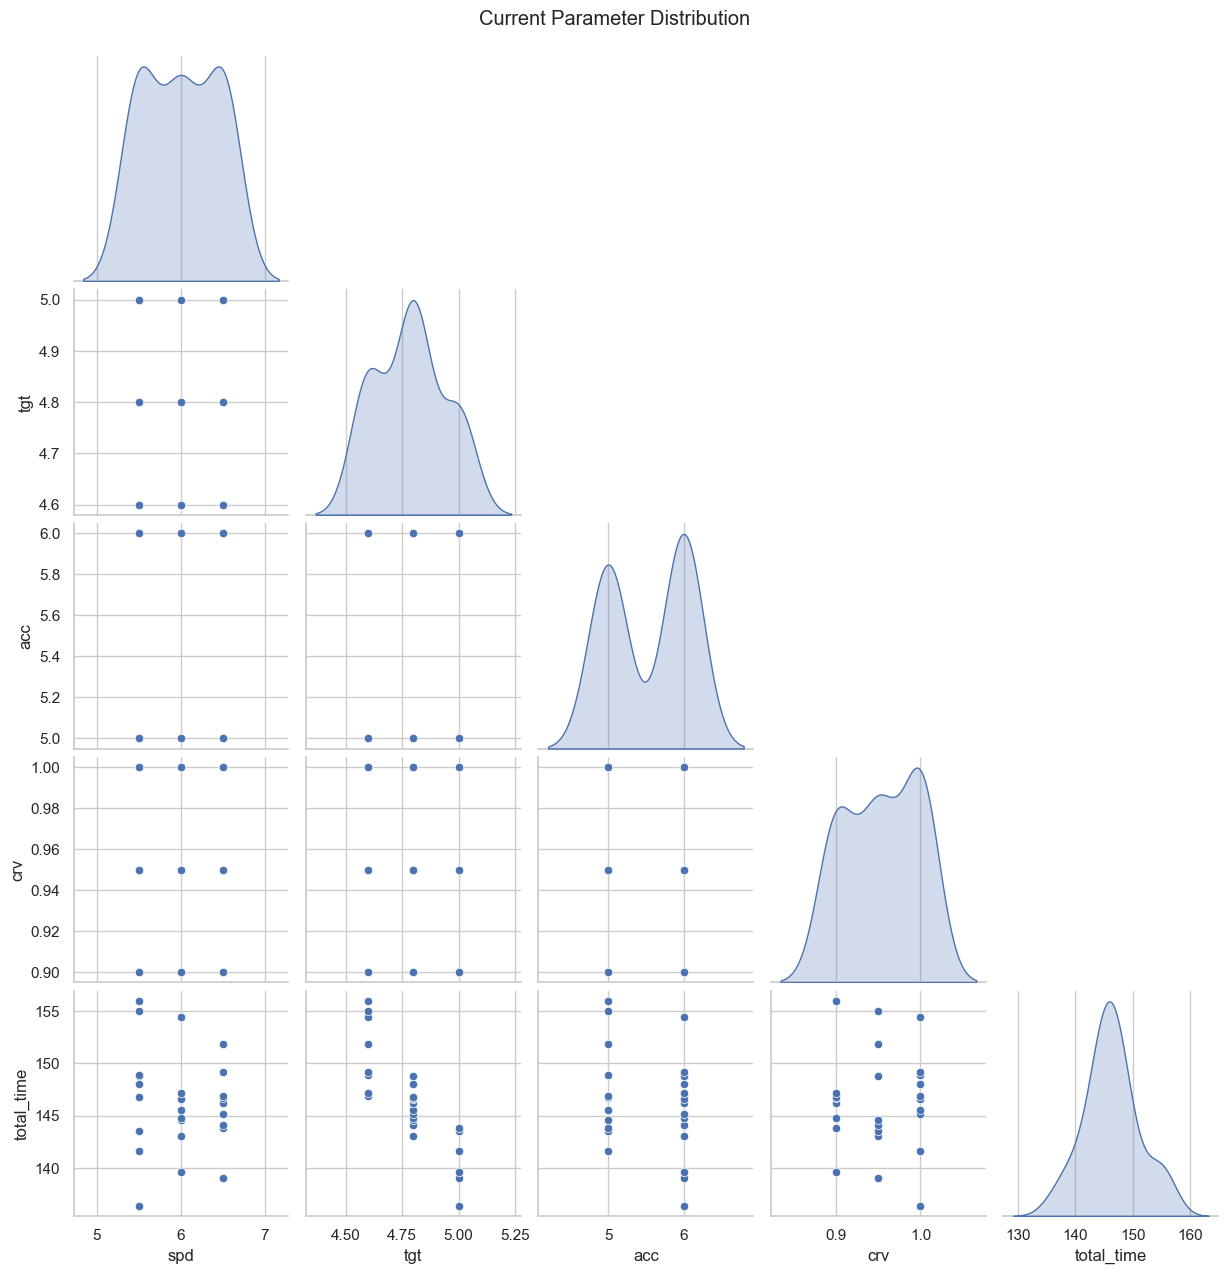

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# best_results(=complete_records)를 사용
if 'best_results' in locals() and not best_results.empty:
    # 인덱스 리셋하여 컬럼으로 변환
    vis_df = best_results.reset_index()
    
    # 보고 싶은 파라미터들
    cols_to_check = ['spd', 'tgt', 'acc', 'crv', 'total_time']
    
    # 페어플롯 그리기
    plt.figure(figsize=(10, 10))
    sns.pairplot(vis_df[cols_to_check], diag_kind='kde', corner=True)
    plt.suptitle("Current Parameter Distribution", y=1.02)
    plt.show()
else:
    print("시각화할 데이터가 없습니다.")